In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import fft
from scipy import signal
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Reading EEG data CSV
data_points=4000
df_EEG = pd.read_csv("C:/Users/agarw/Downloads/EEG_data.csv", delimiter = ";")
df_EEG=df_EEG[0:data_points]

#Reading EMG data CSV
df_EMG=pd.read_excel("C:/Users/agarw/Downloads/EMG_data.xlsx")
df_EMG=df_EMG[0:data_points]

#Concat two datasets 
df=pd.concat([df_EEG,df_EMG],axis=1)
df.head()

,Date,HH,MM,SS,EOG Left,EEG C3-A1,EEG O1-A1,EEG C4-A1,EEG O2-A1,EMG_C1,EMG_C2
0,08/03/2016,1,27,22,"0,78125","5,56640625","-12,40234375","0,9765625","13,76953125",-0.00001,-0.00002
1,08/03/2016,1,27,"22,005","1,953125","4,78515625","-11,23046875","-0,09765625","17,08984375",-0.00001,-0.00002
2,08/03/2016,1,27,"22,01","-1,67E-14","4,296875","-11,23046875","0,9765625","17,96875",-0.00001,-0.00002
3,08/03/2016,1,27,"22,015","0,78125","4,78515625","-12,01171875","6,34765625","20,1171875",-0.00001,-0.00002
4,08/03/2016,1,27,"22,02","0,29296875","4,1015625","-13,18359375","8,10546875","17,3828125",-0.00001,0.00001


In [3]:
#Columns and data types of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4000 non-null   object 
 1   HH         4000 non-null   int64  
 2   MM         4000 non-null   int64  
 3   SS         4000 non-null   object 
 4   EOG Left   4000 non-null   object 
 5   EEG C3-A1  4000 non-null   object 
 6   EEG O1-A1  4000 non-null   object 
 7   EEG C4-A1  4000 non-null   object 
 8   EEG O2-A1  4000 non-null   object 
 9   EMG_C1     4000 non-null   float64
 10  EMG_C2     4000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 343.9+ KB


In [4]:
#Checking for null/missing values values
df.isnull().sum()

Date         0
HH           0
MM           0
SS           0
EOG Left     0
EEG C3-A1    0
EEG O1-A1    0
EEG C4-A1    0
EEG O2-A1    0
EMG_C1       0
EMG_C2       0
dtype: int64

In [5]:
#Finding the start and end of the experiment 
print ('Start time of this record is', df['Date'][0], df['HH'][0],":",df['MM'][0],":",df['SS'][0])
print ('End time of this record is  ', df['Date'].iloc[-1], df['HH'].iloc[-1],":",df['MM'].iloc[-1],":",df['SS'].iloc[-1])

Start time of this record is 08/03/2016 1 : 27 : 22
End time of this record is   08/03/2016 1 : 27 : 41,995


In [6]:
#Creating a timeseries variable
df['Time (s)'] = np.arange(0,len(df)*0.005,0.005)
df.head()

,Date,HH,MM,SS,EOG Left,EEG C3-A1,EEG O1-A1,EEG C4-A1,EEG O2-A1,EMG_C1,EMG_C2,Time (s)
0,08/03/2016,1,27,22,"0,78125","5,56640625","-12,40234375","0,9765625","13,76953125",-0.00001,-0.00002,0.000
1,08/03/2016,1,27,"22,005","1,953125","4,78515625","-11,23046875","-0,09765625","17,08984375",-0.00001,-0.00002,0.005
2,08/03/2016,1,27,"22,01","-1,67E-14","4,296875","-11,23046875","0,9765625","17,96875",-0.00001,-0.00002,0.010
3,08/03/2016,1,27,"22,015","0,78125","4,78515625","-12,01171875","6,34765625","20,1171875",-0.00001,-0.00002,0.015
4,08/03/2016,1,27,"22,02","0,29296875","4,1015625","-13,18359375","8,10546875","17,3828125",-0.00001,0.00001,0.020


In [7]:
#Extract only required columns for the analysis
features = ["EOG Left", "EEG C3-A1", "EEG O1-A1", "EEG C4-A1", "EEG O2-A1","EMG_C1","EMG_C2"]
df_features = df[['Time (s)',"EOG Left", "EEG C3-A1", "EEG O1-A1", "EEG C4-A1", "EEG O2-A1","EMG_C1","EMG_C2"]]
df_features.head()

,Time (s),EOG Left,EEG C3-A1,EEG O1-A1,EEG C4-A1,EEG O2-A1,EMG_C1,EMG_C2
0,0.000,"0,78125","5,56640625","-12,40234375","0,9765625","13,76953125",-0.00001,-0.00002
1,0.005,"1,953125","4,78515625","-11,23046875","-0,09765625","17,08984375",-0.00001,-0.00002
2,0.010,"-1,67E-14","4,296875","-11,23046875","0,9765625","17,96875",-0.00001,-0.00002
3,0.015,"0,78125","4,78515625","-12,01171875","6,34765625","20,1171875",-0.00001,-0.00002
4,0.020,"0,29296875","4,1015625","-13,18359375","8,10546875","17,3828125",-0.00001,0.00001


In [8]:
#EEG C3-A1", "EEG O1-A1", "EEG C4-A1", "EEG O2-A1" are strings. 
#Needed to convert them to float. 
#Then has to Rreplace the comma "," to dot ".".
for x in features[0:-2]:
    df_features[x] = [x.replace(',', '.') for x in df_features[x]]
df_features = df_features.astype('float')
df_features.head()

,Time (s),EOG Left,EEG C3-A1,EEG O1-A1,EEG C4-A1,EEG O2-A1,EMG_C1,EMG_C2
0,0.000,7.812500e-01,5.566406,-12.402344,0.976562,13.769531,-0.00001,-0.00002
1,0.005,1.953125e+00,4.785156,-11.230469,-0.097656,17.089844,-0.00001,-0.00002
2,0.010,-1.670000e-14,4.296875,-11.230469,0.976562,17.968750,-0.00001,-0.00002
3,0.015,7.812500e-01,4.785156,-12.011719,6.347656,20.117188,-0.00001,-0.00002
4,0.020,2.929688e-01,4.101562,-13.183594,8.105469,17.382812,-0.00001,0.00001


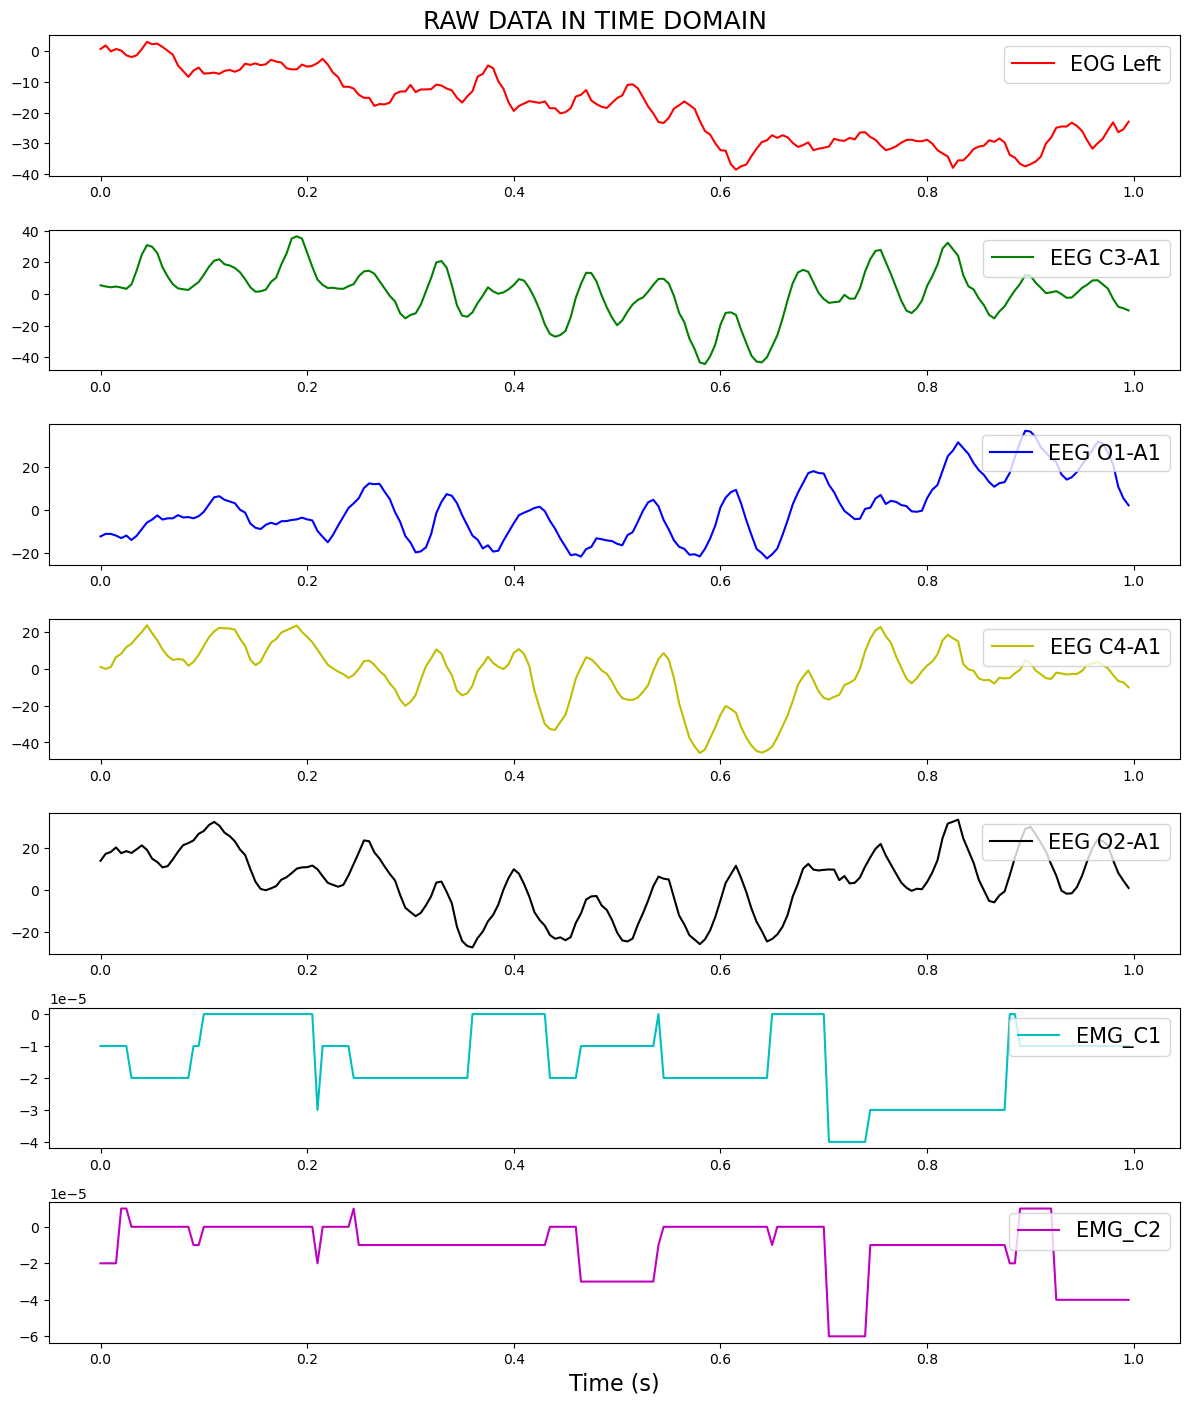

In [9]:
fig, axs = plt.subplots(7)
#fig, axs = plt.subplots(7, sharex=True, sharey=True)
fig.set_size_inches(12,14)
labels = ["EOG Left", "EEG C3-A1", "EEG O1-A1", 'EEG C4-A1', 'EEG O2-A1','EMG_C1','EMG_C2']
colors = ["r","g","b",'y',"k","c","m"]

plt.suptitle('RAW DATA IN TIME DOMAIN', fontsize = 18)
for i,ax in enumerate(axs):
  axs[i].plot(df_features['Time (s)'][:200], df_features[labels[i]][:200],color=colors[i],label=labels[i])
  axs[i].legend(loc="upper right",fontsize = 15)
    
fig.tight_layout()  
plt.xlabel('Time (s)',fontsize = 16)
plt.show()

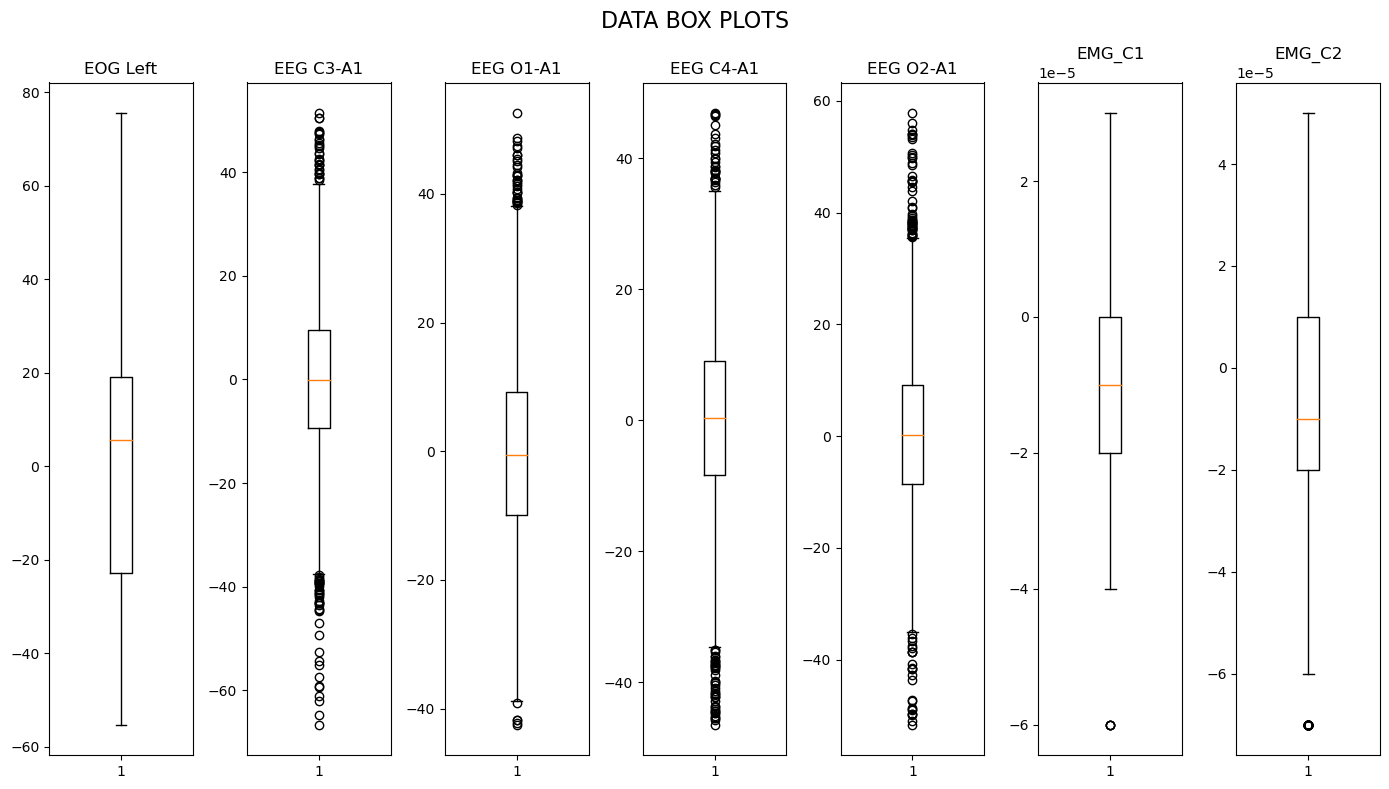

In [10]:
fig, axs = plt.subplots(7, sharex=True, sharey=True)
fig.set_size_inches(14,8)
labels = ["EOG Left", "EEG C3-A1", "EEG O1-A1", 'EEG C4-A1', 'EEG O2-A1','EMG_C1','EMG_C2']

plt.suptitle('DATA BOX PLOTS', fontsize = 16)
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.boxplot(df_features[labels[i]])
    plt.title(labels[i])
    
plt.tight_layout()  
plt.show()

In [11]:
df_features_fft = df_features.copy()
df_features_fft = df_features_fft[labels].apply(fft)
df_features_fft['Time (s)'] = df_features['Time (s)']
df_features_fft.head()

AssertionError: 

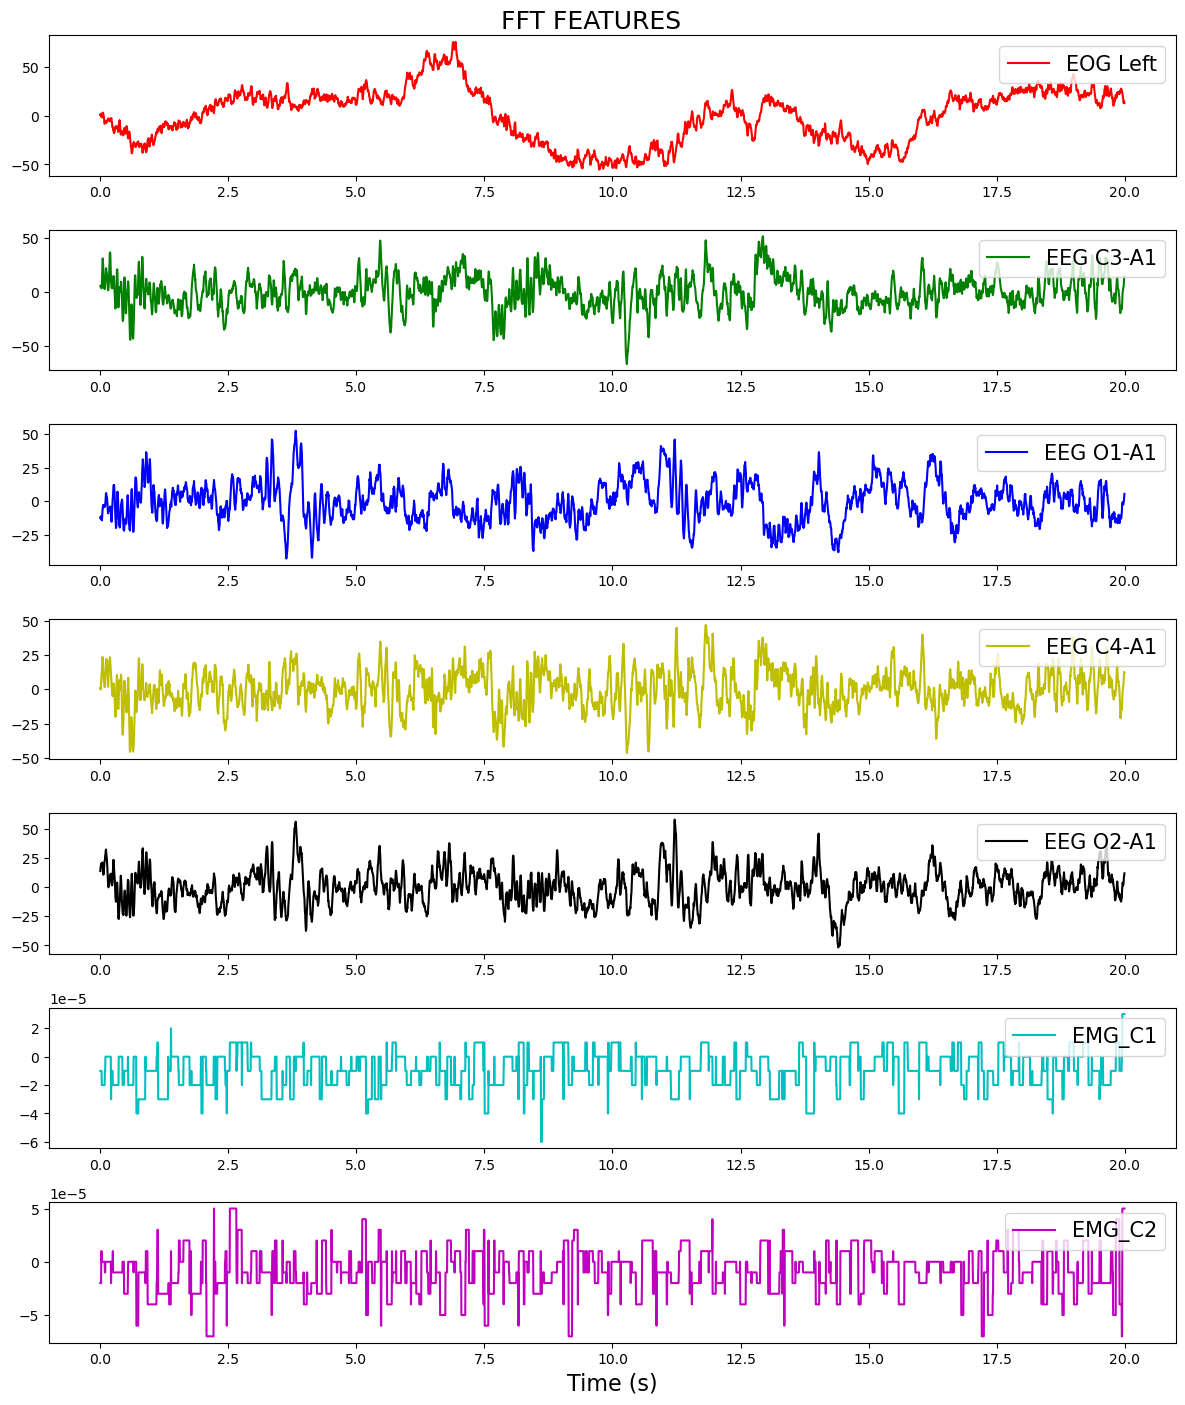

In [12]:
# plot these FFT features
#fig, axs = plt.subplots(7, sharex=True, sharey=True)
fig, axs = plt.subplots(7)
fig.set_size_inches(12, 14)
colors = ["r","g","b",'y',"k","c","m"]

plt.suptitle('FFT FEATURES', fontsize = 18)
for i,ax in enumerate(axs):
  axs[i].plot(df_features_fft['Time (s)'], df_features_fft[labels[i]],color=colors[i],label=labels[i])
  axs[i].legend(loc="upper right",fontsize = 15)

fig.tight_layout() 
plt.xlabel('Time (s)', fontsize = 16)
plt.show()

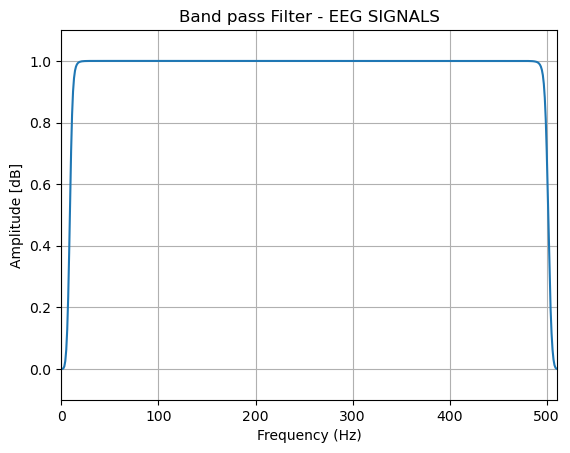

In [13]:
limits=[10,500]
SR=1024
order=4

b, a = signal.butter(4, limits, 'bandpass',fs=SR )
w, h = signal.freqz(b, a)

plt.plot((1024* 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
plt.title('Band pass Filter - EEG SIGNALS')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

sos = signal.butter(order,limits, 'bandpass', fs=SR,output="sos")
filtered_df=df_features.copy()
EMG_Columns=[ "EMG_C1","EMG_C2"]

for column_name in EMG_Columns:
    filtered_df[column_name]=signal.sosfilt(sos, df_features[column_name])

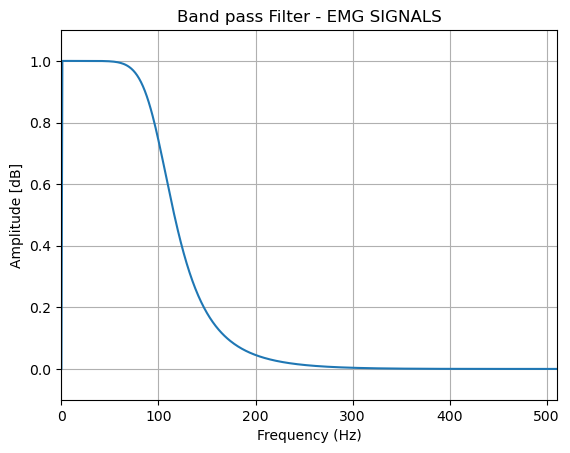

In [14]:
limits=[0.05,100]
SR=1000
order=4

b, a = signal.butter(4, limits, 'bandpass',fs=SR )
w, h = signal.freqz(b, a)

plt.plot((1024* 0.5 / np.pi) * w, abs(h))
plt.title('Band pass Filter - EMG SIGNALS')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

sos = signal.butter(order,limits, 'bandpass', fs=SR,output="sos")
filtered_df=df_features.copy()
EEG_Columns=[ "EEG C3-A1", "EEG O1-A1", "EEG C4-A1", "EEG O2-A1"]

for column_name in EEG_Columns:
    filtered_df[column_name]=signal.sosfilt(sos, df_features[column_name])

In [15]:
filtered_df.head()

,Time (s),EOG Left,EEG C3-A1,EEG O1-A1,EEG C4-A1,EEG O2-A1,EMG_C1,EMG_C2
0,0.000,7.812500e-01,0.026809,-0.059731,0.004703,0.066316,-0.00001,-0.00002
1,0.005,1.953125e+00,0.193808,-0.434557,0.029488,0.504718,-0.00001,-0.00002
2,0.010,-1.670000e-14,0.670935,-1.520319,0.090031,1.856174,-0.00001,-0.00002
3,0.015,7.812500e-01,1.520904,-3.497452,0.215426,4.502364,-0.00001,-0.00002
4,0.020,2.929688e-01,2.605581,-6.111520,0.524687,8.278765,-0.00001,0.00001


In [16]:
#Adaptive threshold = 1.2 time Mean absolute value 
filtered_df_eye=filtered_df.copy()

for column_name in EEG_Columns:
    data=filtered_df[column_name]
    MAV=sum(abs(data))/len(data)
    filtered_df_eye[column_name]=data[(data>-1.2*MAV) & (data<1.2*MAV)] 

filtered_df_eye = filtered_df_eye.dropna(how='any',axis=0)

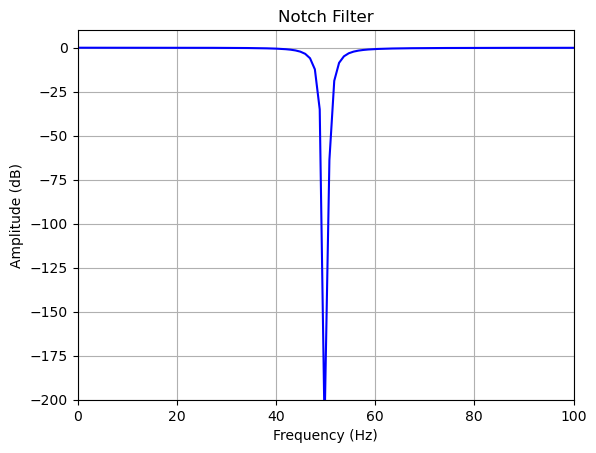

In [17]:
#Both EMG and EEG signals
f0 = 50.0 #Remove 50 Hz signal
b, a = signal.iirnotch(f0,25, SR)
freq, h = signal.freqz(b, a, fs=SR)

plt.plot(freq,300*np.log10(abs(h)), color='blue')
plt.title("Notch Filter")
plt.ylabel("Amplitude (dB)")
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 100])
plt.ylim([-200, 10])
plt.grid()
plt.show()

Notched_Columns=[ "EOG Left","EEG C3-A1", "EEG O1-A1", "EEG C4-A1", "EEG O2-A1","EMG_C1","EMG_C2"]
Notched_df=filtered_df.copy()
for column_name in Notched_Columns:
    Notched_df[column_name]=signal.filtfilt(b, a, filtered_df[column_name])

In [18]:
Notched_df.head()

,Time (s),EOG Left,EEG C3-A1,EEG O1-A1,EEG C4-A1,EEG O2-A1,EMG_C1,EMG_C2
0,0.000,1.008256,0.401113,0.381357,0.050932,0.495750,-0.000011,-0.000019
1,0.005,2.238685,0.622287,0.091736,0.105920,0.520538,-0.000011,-0.000020
2,0.010,0.316177,1.111879,-0.959500,0.188408,1.451294,-0.000011,-0.000020
3,0.015,1.096735,1.930715,-2.956466,0.325045,3.710486,-0.000010,-0.000020
4,0.020,0.576217,2.943124,-5.643269,0.633567,7.171848,-0.000010,0.000010


In [19]:
WINDOW_SIZE= int(0.250/0.005)    #250ms
INCREMENT=int(0.100/0.005)        #100ms
Segmented_features=[]

filtered_df_list=Notched_df.values[:,2:]
for i in range(0,len(filtered_df_list),INCREMENT):
    frames=filtered_df_list[i:i+WINDOW_SIZE]
    Segmented_features.append(frames)
    

In [20]:
#Size of the Segmented feature matrix
print(f"Total Segments {len(Segmented_features)}")
print(f"Shape of a one segment {Segmented_features[0].shape}")

Total Segments 200
Shape of a one segment (50, 6)


In [21]:
order=4
AR_Features_segments=[]

for j in range(0,len(Segmented_features)):
    AR_Features=np.array([])
    for i in range(0,Segmented_features[j].shape[1]):
        model = AutoReg(Segmented_features[j][:,i], order-1,old_names=False).fit()
        AR_Features=np.append(AR_Features,model.params)
    AR_Features_segments.append(AR_Features)
    
AR_Features_segments=np.array(AR_Features_segments)

In [22]:
AR_Features_segments.shape
#(Segments,AR fetures count (Channels*Order))

(200, 24)

In [23]:
#Sample Entropy
from pyentrp import entropy as ent
m=2

Sample_entrphy_list=[]
for j in range(0,len(Segmented_features)):
    entropy_array=np.array([])
    for i in range(0,Segmented_features[j].shape[1]):
        data=Segmented_features[j][:,i]
        r=0.2*np.std(data)  #0.2*std of a segment
        sample_entropy = ent.sample_entropy(data,m, r)
        entropy_array=np.append(entropy_array,sample_entropy)
    Sample_entrphy_list.append(entropy_array)
    
Sample_entrphy_list=np.array(Sample_entrphy_list)

ModuleNotFoundError: No module named 'pyentrp'

In [24]:
#b-loss Energy Entrophy
from scipy.stats import entropy as loss_entrophy

loss_entrophy_list=[]
for j in range(0,len(Segmented_features)):
    loss_ent=np.array([])
    for i in range(0,Segmented_features[j].shape[1]):
        data=Segmented_features[j][:,i]
        loss_e = loss_entrophy(data,base=2)
        loss_ent=np.append(loss_ent,loss_e)
    loss_entrophy_list.append(loss_ent)
    
loss_entrophy_list=np.array(loss_entrophy_list)

In [25]:
loss_entrophy_list.shape

(200, 6)

In [26]:
RMS_list=[]
for j in range(0,len(Segmented_features)):
    RMS_values=np.array([])
    for i in range(0,Segmented_features[j].shape[1]):
        data=Segmented_features[j][:,i]
        RMS=np.mean(data**2)
        RMS_values=np.append(RMS_values,RMS)
    RMS_list.append(RMS_values)
    
RMS_list=np.array(RMS_list)

In [27]:
RMS_list.shape

(200, 6)

In [28]:
AMP_list=[]
for j in range(0,len(Segmented_features)):
    AMP_values=np.array([])
    for i in range(0,Segmented_features[j].shape[1]):
        data=Segmented_features[j][:,i]
        AMP=np.max(data)
        AMP_values=np.append(AMP_values,AMP)
    AMP_list.append(AMP_values)
    
AMP_list=np.array(AMP_list)

In [29]:
AMP_list.shape

(200, 6)

In [30]:
#Here wavelength for all the segments are equal
WL=len(Segmented_features[0])*0.005

In [31]:
def freequency_fetures(data,thresh=120):   
    sampling_rate=1024
    N=10
    MPF=[]
    #data=Segmented_features[0][:,1]
    for i in range(0,len(data)-N):
        signal=data[i:(i+N)]
        FT=np.fft.fft(signal, axis=0)
        psd=FT*np.conj(FT)
        NFFT=len(FT)
        f =(np.arange(0,NFFT/2)*sampling_rate)/N
        D_1=0
        N_1=0
        for j in np.arange(1,NFFT/2):
           j=int(j) 
           D_1=D_1+f[j]*psd[j]
           N_1=N_1+psd[j]   
           MPF.append(D_1/N_1)
            
    MPF_array=np.array(MPF)
    mean_f=np.mean(MPF_array)
    median_f=np.median(MPF_array)
    
    sum_low_f=MPF_array[MPF_array<thresh]
    sum_high_f=MPF_array[MPF_array>thresh]
    f_ratio=sum(sum_low_f)/sum(sum_high_f)
    
    return int(mean_f),int(median_f),int(f_ratio)

#plt.plot(MPF)        
#plt.show()

In [32]:
mean_f,median_f,f_ratio = freequency_fetures(data)

f_values_list=[]
for j in range(0,len(Segmented_features)):
    f_vals=np.array([])
    for i in range(0,Segmented_features[j].shape[1]):
        data=Segmented_features[j][:,i]
        f=freequency_fetures(data)
        f_vals=np.append(f_vals,f)
    f_values_list.append(f_vals)
    
f_values_list=np.array(f_values_list)

f_mean_lst=f_values_list[:,[0,3,6,9]]
f_median_lst=f_values_list[:,[1,4,7,10]]
f_ratio_lst=f_values_list[:,[2,5,8,11]]

In [33]:
f_mean_lst.shape,f_median_lst.shape,f_ratio_lst.shape

((200, 4), (200, 4), (200, 4))

In [34]:
#Making the Combined Feature matrix
#AR coefficients + Freequency domain features
Final_feature_matrix=np.concatenate((AR_Features_segments,f_values_list),axis=1)
Final_feature_matrix.shape

#24 AutoRegressor coefficients + 18 Freequency features [(4+3)features*6 channels]

(200, 42)

In [35]:
import random
random.seed(15)

movements_dct={0:"Hand Open",1:"Hand Close",2:"Wrist Pronation",3:"Wrist Supination",4:"No Movement"}
y_val= [random.randint(0,4) for i in range(Final_feature_matrix.shape[0])]

In [36]:
#Making training and testing sets
#80% for training
#20% for testing

x_train,x_test,y_train,y_test=train_test_split(Final_feature_matrix,y_val,test_size=0.2,random_state=25)
print(f"Training Data Points-{len(x_train)} and Testing Data Points-{len(x_test)}")

Training Data Points-160 and Testing Data Points-40


In [37]:
def pie_chart(y_val):
    plt.figure(figsize=(8,8))
    count=[y_val.count(i) for i in range(5)]
    plt.title('Data Distrubution',fontsize=14)
    
    val=movements_dct.values()
    
    plt.pie(count,labels=val,shadow = True,autopct='%1.1f%%',textprops={'fontsize': 14})
    #plt.legend(loc='best')
    plt.show()

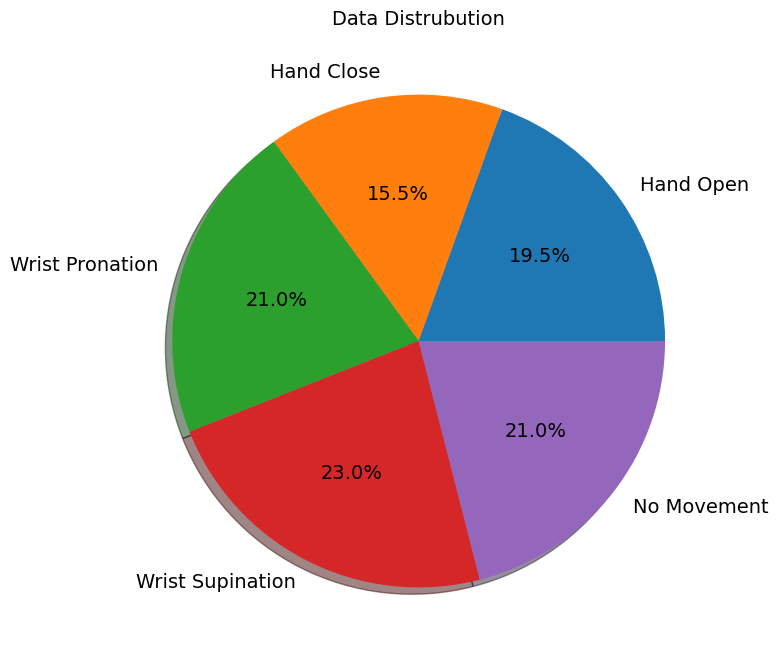

In [38]:
pie_chart(y_val)

In [39]:
def Confussion_Matrix(cm,title="Confusion Matrix"):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True,fmt="d", cmap='YlGnBu', linecolor='black', linewidths=1,annot_kws={"size": 16})
    plt.title(title,fontsize=15)
    plt.xlabel("Actual",fontsize=15)
    plt.ylabel("Predicted",fontsize=15)

SVC-Training Accuracy score: 0.2375
SVC-Testing Accuracy score: 0.175

Time Taken: 0.06821322441101074 s

                  precision    recall  f1-score   support

       Hand Open       0.00      0.00      0.00        15
      Hand Close       0.00      0.00      0.00         3
 Wrist Pronation       0.12      0.33      0.17         6
Wrist Supination       0.27      0.40      0.32        10
     No Movement       0.12      0.17      0.14         6

        accuracy                           0.17        40
       macro avg       0.10      0.18      0.13        40
    weighted avg       0.10      0.17      0.13        40



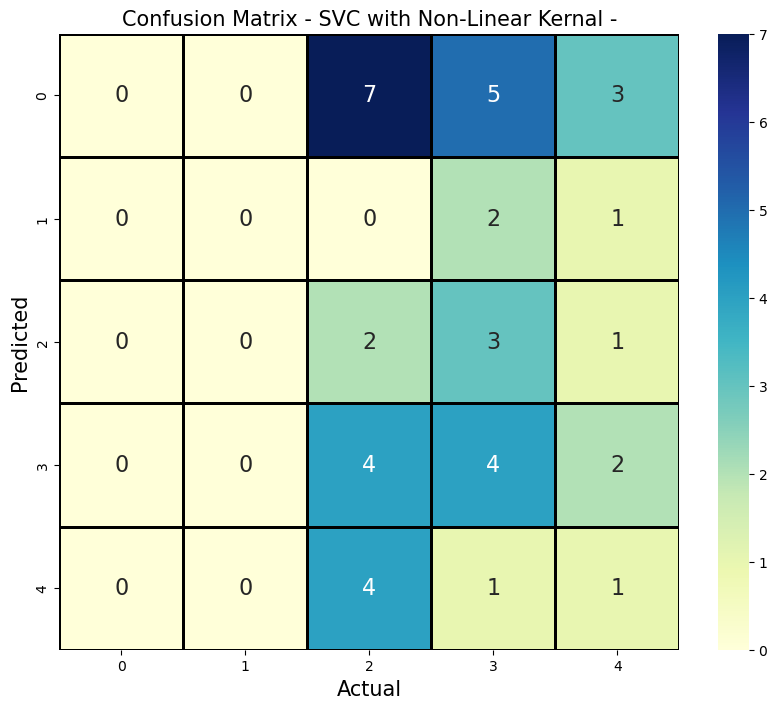

In [40]:
START=time.time()
from sklearn.svm import SVC
model_svc=SVC(kernel="rbf")
model_svc.fit(x_train,y_train)
scores=cross_val_score(model_svc,x_train,y_train,cv=5)
predictions_svc=model_svc.predict(x_test)

print("SVC-Training Accuracy score: "+str(round(scores.mean(),4)))
print("SVC-Testing Accuracy score: "+str(round(accuracy_score(y_test,predictions_svc),4)))
STOP=time.time()
print(f"\nTime Taken: {STOP-START} s\n")

cm_svc=confusion_matrix(y_test,predictions_svc)
Confussion_Matrix(cm_svc,title="Confusion Matrix - SVC with Non-Linear Kernal -")
print(classification_report(y_test,predictions_svc,target_names=movements_dct.values()))

KNN-Training Accuracy score: 0.2062
KNN-Testing Accuracy score: 0.175

Time Taken: 0.5754415988922119 s

                  precision    recall  f1-score   support

       Hand Open       0.25      0.13      0.17        15
      Hand Close       0.00      0.00      0.00         3
 Wrist Pronation       0.20      0.33      0.25         6
Wrist Supination       0.17      0.20      0.18        10
     No Movement       0.20      0.17      0.18         6

        accuracy                           0.17        40
       macro avg       0.16      0.17      0.16        40
    weighted avg       0.20      0.17      0.18        40



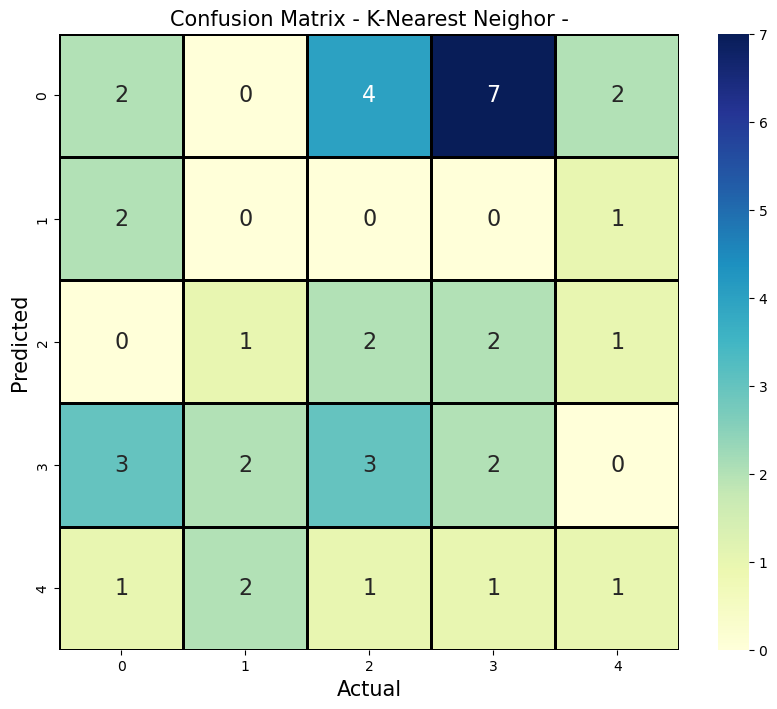

In [41]:
START=time.time()
from sklearn.neighbors import KNeighborsClassifier
model_KNN= KNeighborsClassifier(n_neighbors=5)
model_KNN.fit(x_train,y_train)
scores=cross_val_score(model_KNN,x_train,y_train,cv=5)
predictions_KNN=model_KNN.predict(x_test)

print("KNN-Training Accuracy score: "+str(round(scores.mean(),4)))
print("KNN-Testing Accuracy score: "+str(round(accuracy_score(y_test,predictions_KNN),4)))
STOP=time.time()
print(f"\nTime Taken: {STOP-START} s\n")

cm_KNN=confusion_matrix(y_test,predictions_KNN)
Confussion_Matrix(cm_KNN,title="Confusion Matrix - K-Nearest Neighor -")
print(classification_report(y_test,predictions_KNN,target_names=movements_dct.values()))

QDA-Training Accuracy score: 0.1812
QDA-Testing Accuracy score: 0.15

Time Taken: 0.03567361831665039 s

                  precision    recall  f1-score   support

       Hand Open       0.00      0.00      0.00        15
      Hand Close       0.00      0.00      0.00         3
 Wrist Pronation       0.18      0.33      0.24         6
Wrist Supination       0.19      0.40      0.26        10
     No Movement       0.00      0.00      0.00         6

        accuracy                           0.15        40
       macro avg       0.07      0.15      0.10        40
    weighted avg       0.07      0.15      0.10        40



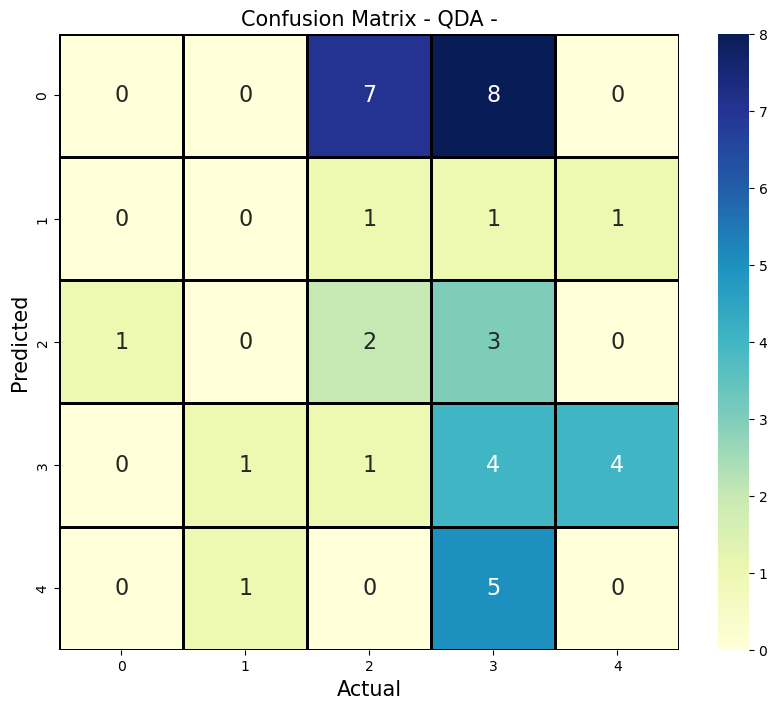

In [42]:
START=time.time()
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model_QDA= QuadraticDiscriminantAnalysis()
model_QDA.fit(x_train,y_train)
scores=cross_val_score(model_QDA,x_train,y_train,cv=5)
predictions_QDA=model_QDA.predict(x_test)

print("QDA-Training Accuracy score: "+str(round(scores.mean(),4)))
print("QDA-Testing Accuracy score: "+str(round(accuracy_score(y_test,predictions_QDA),4)))
STOP=time.time()
print(f"\nTime Taken: {STOP-START} s\n")

cm_QDA=confusion_matrix(y_test,predictions_QDA)
Confussion_Matrix(cm_QDA,title="Confusion Matrix - QDA -")
print(classification_report(y_test,predictions_QDA,target_names=movements_dct.values()))

In [43]:
%%html
<marquee style='width: 100% ;height:100%; color: #0F52BA ;'>
    <b>Thank you!!</b>
    </marquee> 